### IMPORT ALL LIBRARY

In [19]:
!pip install pydot

In [20]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf logs/ 

In [4]:
import numpy as np
import pandas as pd
from numpy import argmax
import random
import tensorflow as tf
import datetime,os
from tensorboard.plugins.hparams import api as hp
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential, layers, datasets
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, Conv2D,MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# PART 1 (CREATING INPUT PIPELINES)

In [5]:
train_ds, test_ds = tfds.load('cifar10', split=['train','test'], as_supervised=True,batch_size=-1)

train_images, train_labels   = tfds.as_numpy(train_ds)
test_images, test_labels   = tfds.as_numpy(test_ds)
train_images, test_images = train_images / 255.0, test_images / 255.0

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [6]:
train_images.shape

(50000, 32, 32, 3)

In [7]:
# DATA AUGMENTATION 
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [8]:
# All the classes of the images to predict
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

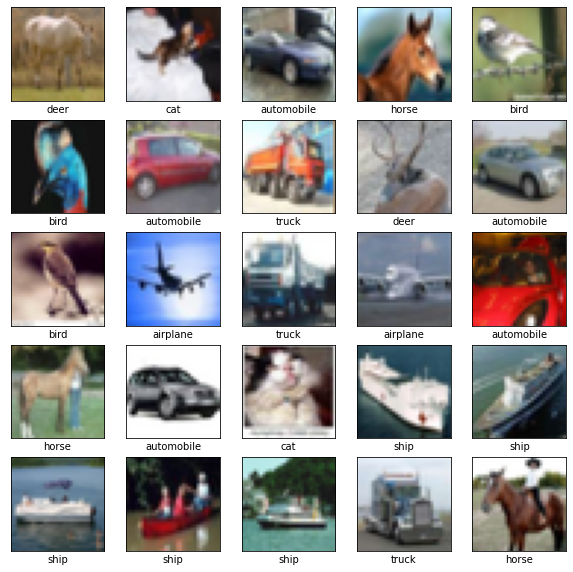

In [9]:
# Plotting the training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    p = random.randint(0,train_images.shape[0])
    plt.imshow(train_images[p])
    plt.xlabel(class_names[train_labels[p]])
plt.show()

## HPARAM DASHBOARD FOR HYPERPARAMTER TUNING WITH TENSORBOARD

In [10]:
# DIFFERENT RANGES OF PARAMETERS FOR TUNING

HP_DROPOUT         =        hp.HParam('dropout', hp.Discrete([0.0,0.1, 0.2,0.3]))
HP_OPTIMIZER       =        hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_NUM_LAYERS      =        hp.HParam('num_layers', hp.Discrete([2,3,4]))
HP_BATCH_SIZE      =        hp.HParam('batch_size', hp.Discrete([32,64,128]))
HP_KERNEL_SIZE     =        hp.HParam('kernel_size', hp.Discrete([3,5]))
HP_NUM_KERNELS     =        hp.HParam('num_kernels', hp.Discrete([16, 32,64]))
HP_LEARNING_RATE   =        hp.HParam('learning_rate', hp.Discrete([0.5,0.1,0.01,0.001]))
HP_REGULAR_PARAM   =        hp.HParam('regular_param', hp.Discrete([0.001,0.005,0.0001]))

METRIC_ACCURACY    = 'accuracy'


### MODEL

In [11]:
def create_model(hparams):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(32, 32, 3)))
    
    k=1
    for i in range(hparams[HP_NUM_LAYERS]):
        
        model.add(Conv2D(hparams[HP_NUM_KERNELS]*(k), (hparams[HP_KERNEL_SIZE],hparams[HP_KERNEL_SIZE]),
                         activation='relu',padding='same',kernel_regularizer=l2(hparams[HP_REGULAR_PARAM])))
        
        model.add(BatchNormalization())
        model.add(Dropout(hparams[HP_DROPOUT]))
        
        model.add(Conv2D(hparams[HP_NUM_KERNELS]*(k), (hparams[HP_KERNEL_SIZE],hparams[HP_KERNEL_SIZE]),
                         activation='relu',padding='same',kernel_regularizer=l2(hparams[HP_REGULAR_PARAM])))
        
        model.add(BatchNormalization())
        model.add(MaxPool2D((2, 2)))
        model.add(Dropout(hparams[HP_DROPOUT]))
        
        k=k*2
        
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]+0.2))
    model.add(Dense(10, activation='softmax'))
    
    #setting the optimizer and learning rate
    
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]

    
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    # Comiple the mode with the optimizer and learninf rate specified in hparams
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [12]:
def train_test_model(run_dir,hparams):
    tf.keras.backend.clear_session()
    model = create_model(hparams)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3)
    history = model.fit(datagen.flow(train_images, train_labels,
                                     batch_size=hparams[HP_BATCH_SIZE]),
                        epochs=30,
                        callbacks=[tf.keras.callbacks.TensorBoard(run_dir, update_freq='epoch',profile_batch=0,), 
                                   hp.KerasCallback(run_dir, hparams),reduce_lr],
                        validation_data = (test_images, test_labels))
    accuracy = max(history.history['val_accuracy']) #model.evaluate(test_images, test_labels)
    print(accuracy)
    return accuracy

In [13]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams) 
        accuracy = train_test_model(run_dir,hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [14]:
# CALL TO RUN FUNCTION WITH DIFFERENT RANDOM PARAMETERS FOR TRAINING AND SAVING RESULTS ON LOG FILE

session_num = 30

for i in range(20):
    
    hparams = {
        HP_DROPOUT: random.sample(HP_DROPOUT.domain.values, 1)[0] ,
        HP_OPTIMIZER: random.sample(HP_OPTIMIZER.domain.values, 1)[0] ,
        HP_NUM_LAYERS : random.sample(HP_NUM_LAYERS .domain.values, 1)[0] ,
        HP_BATCH_SIZE: random.sample(HP_BATCH_SIZE.domain.values, 1)[0] ,
        HP_KERNEL_SIZE: random.sample(HP_KERNEL_SIZE.domain.values, 1)[0] ,
        HP_NUM_KERNELS: random.sample(HP_NUM_KERNELS.domain.values, 1)[0] ,
        HP_LEARNING_RATE: random.sample(HP_LEARNING_RATE.domain.values, 1)[0],
        HP_REGULAR_PARAM: random.sample(HP_REGULAR_PARAM.domain.values, 1)[0] ,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/'+ run_name, hparams)
    session_num += 1

--- Starting trial: run-30
{'dropout': 0.2, 'optimizer': 'adam', 'num_layers': 2, 'batch_size': 32, 'kernel_size': 5, 'num_kernels': 16, 'learning_rate': 0.001, 'regular_param': 0.001}
Epoch 1/30


2021-10-03 10:44:16.556790: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-03 10:44:17.370635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-03 10:44:17.404107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1563/1563 [==============================] - 35s 18ms/step - loss: 1.8690 - accuracy: 0.3330 - val_loss: 1.9719 - val_accuracy: 0.3448
Epoch 2/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4721 - accuracy: 0.4946 - val_loss: 1.6350 - val_accuracy: 0.4567
Epoch 3/30
1563/1563 [==============================] - 29s 19ms/step - loss: 1.3674 - accuracy: 0.5441 - val_loss: 1.3792 - val_accuracy: 0.5482
Epoch 4/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3154 - accuracy: 0.5676 - val_loss: 1.5915 - val_accuracy: 0.4991
Epoch 5/30
1563/1563 [==============================] - 29s 18ms/step - loss: 1.2937 - accuracy: 0.5821 - val_loss: 1.3217 - val_accuracy: 0.5782
Epoch 6/30
1563/1563 [==============================] - 29s 18ms/step - loss: 1.2625 - accuracy: 0.5914 - val_loss: 1.5503 - val_accuracy: 0.5365
Epoch 7/30
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2438 - accuracy: 0.6036 - val_loss: 1.5243 - val_accura

In [16]:
# LOG FILE IS ZIPPED FOR DOWNLOADING AND SAVING
import shutil
shutil.make_archive('logs', 'zip', './logs')

'/kaggle/working/logs.zip'

#### MODEL HYPERPARAMETERS ARE TUNED SEPARATELY ON DIFFERENT SYSTEMS AND 100 RANDOM POINTS ARE TRAINED TO GIVE BEST PARAMETER WHICH AGAIN TRAINED ON 100 EPOCHS 

### BEST PARAMETER


In [ ]:
# 'dropout'        = 0.2
# 'optimizer'      = SGD
# 'num_layers'     = 3
# 'batch_size'     = 64
# 'kernel_size'    = 3
# 'num_kernels'    = 64
# 'learning_rate'  = 0.1
# 'regular_param'  = 0.0001

# ACCURACY         = 0.8992

#### MODEL IS RETRAINED WITH BEST PARAMETERS FOR 100 EPOCH

DUE TO LOW COMPUTATION POWER AND TIME CONSTRAINT MODEL IS NOT FULLY OPTIMIZED TO REQUIRED ACCURACY OF 95%

In [10]:
# SAVED MODEL WITH BEST ACCURACY
filepath = './cifar10_model/model_checkpoint'

In [11]:
# Loading the best model
model = tf.keras.models.load_model(filepath)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0

In [12]:
# evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=3)
print('Test Accuracy: %.4f' % acc)

Test Accuracy: 0.8992


In [13]:
predictions = np.argmax(model.predict(test_images, verbose=0),axis=1)

In [14]:
print(confusion_matrix(test_labels, predictions))

[[922   9  15   4   5   0   2   2  31  10]
 [  4 968   0   0   0   0   1   0   6  21]
 [ 24   0 861  17  26  14  35  11   4   8]
 [ 11   5  22 770  33  68  45  19  13  14]
 [  2   1  21  17 898   4  36  19   1   1]
 [  2   3  25  96  25 787  24  24   4  10]
 [  4   3  11  14   6   2 956   1   1   2]
 [  6   0   9   5  23   7   8 934   4   4]
 [ 21   7   2   1   0   0   4   0 951  14]
 [ 11  28   1   3   0   0   2   0  10 945]]


In [15]:
print(classification_report(test_labels, predictions,target_names = class_names))

              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.86      0.88      1000
         cat       0.83      0.77      0.80      1000
        deer       0.88      0.90      0.89      1000
         dog       0.89      0.79      0.84      1000
        frog       0.86      0.96      0.90      1000
       horse       0.92      0.93      0.93      1000
        ship       0.93      0.95      0.94      1000
       truck       0.92      0.94      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [16]:
%tensorboard --logdir='logs/hparam_tuning/'

Reusing TensorBoard on port 6006 (pid 16992), started 0:26:56 ago. (Use '!kill 16992' to kill it.)

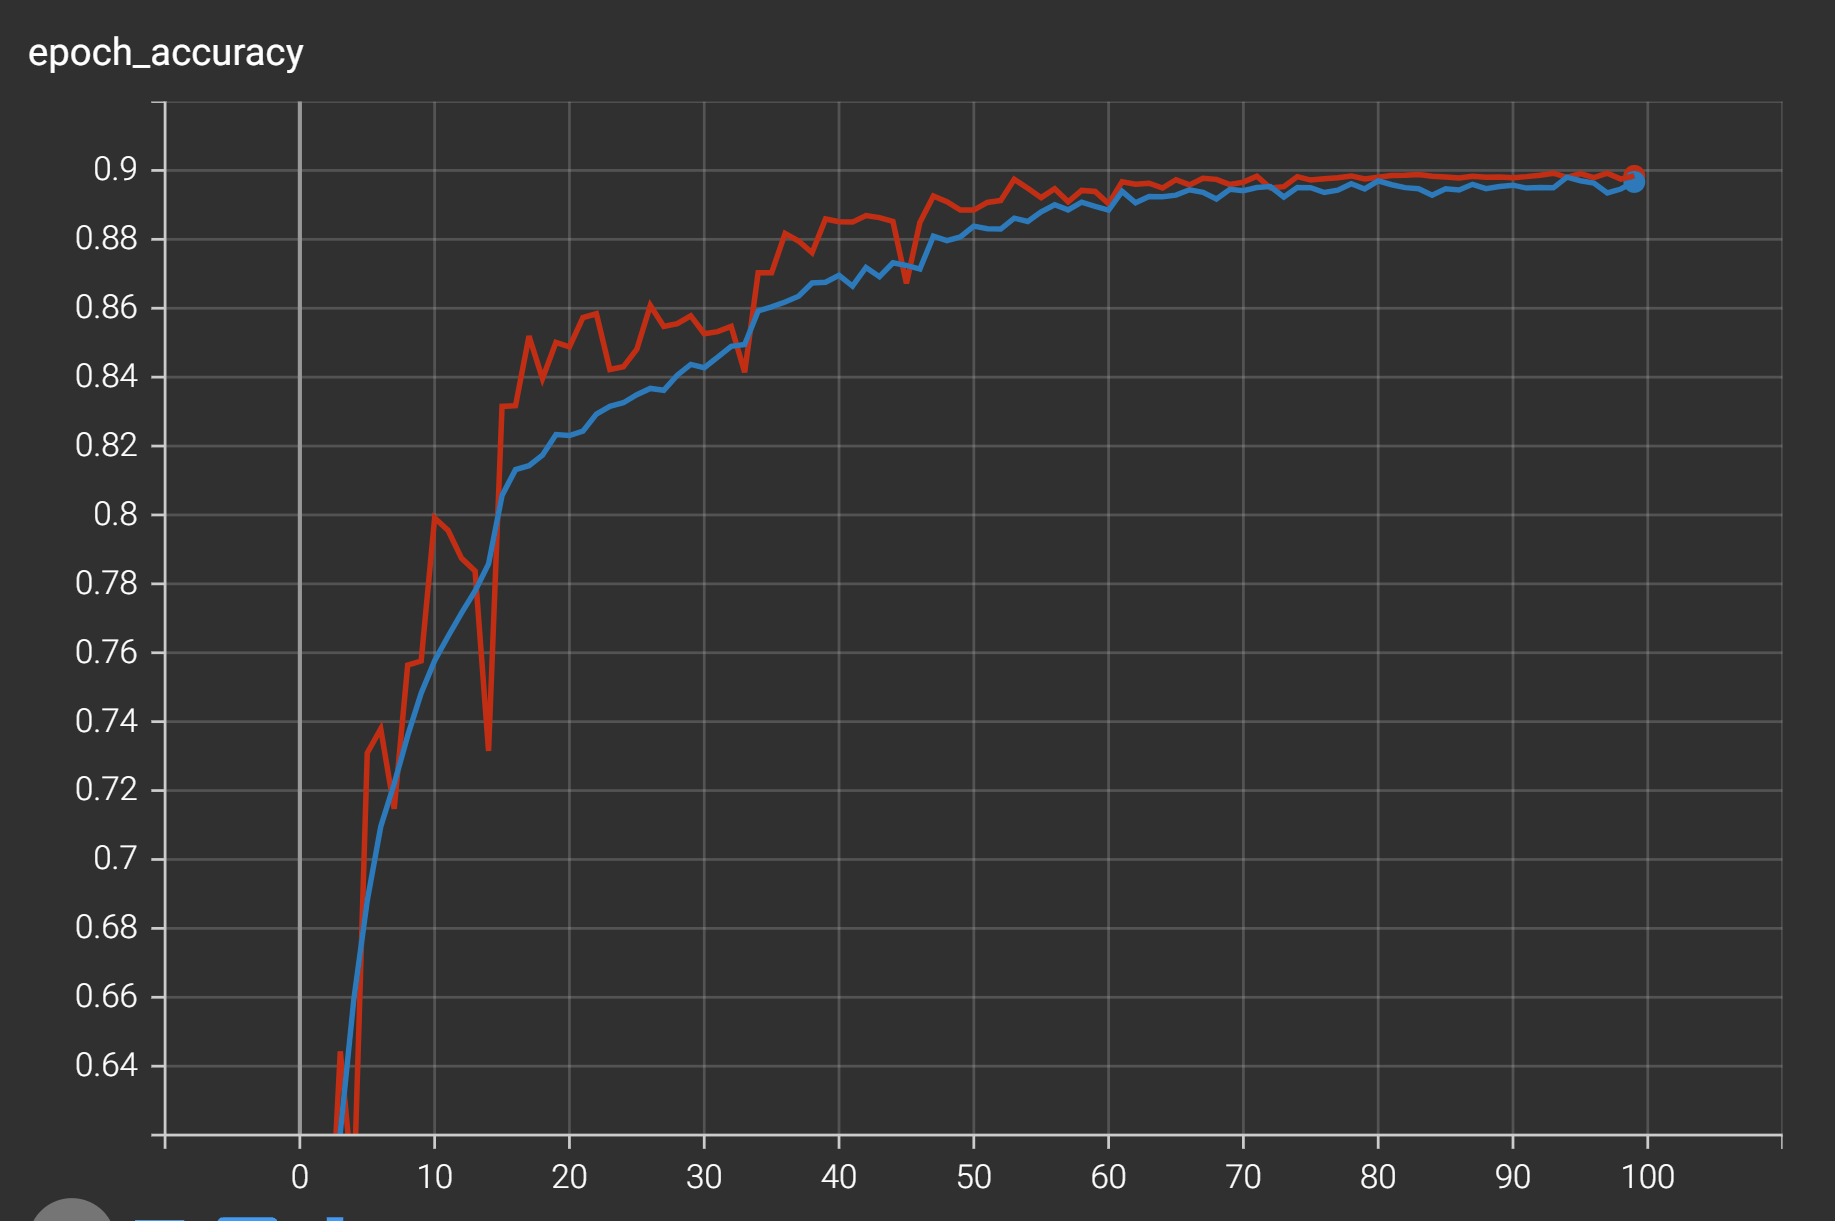

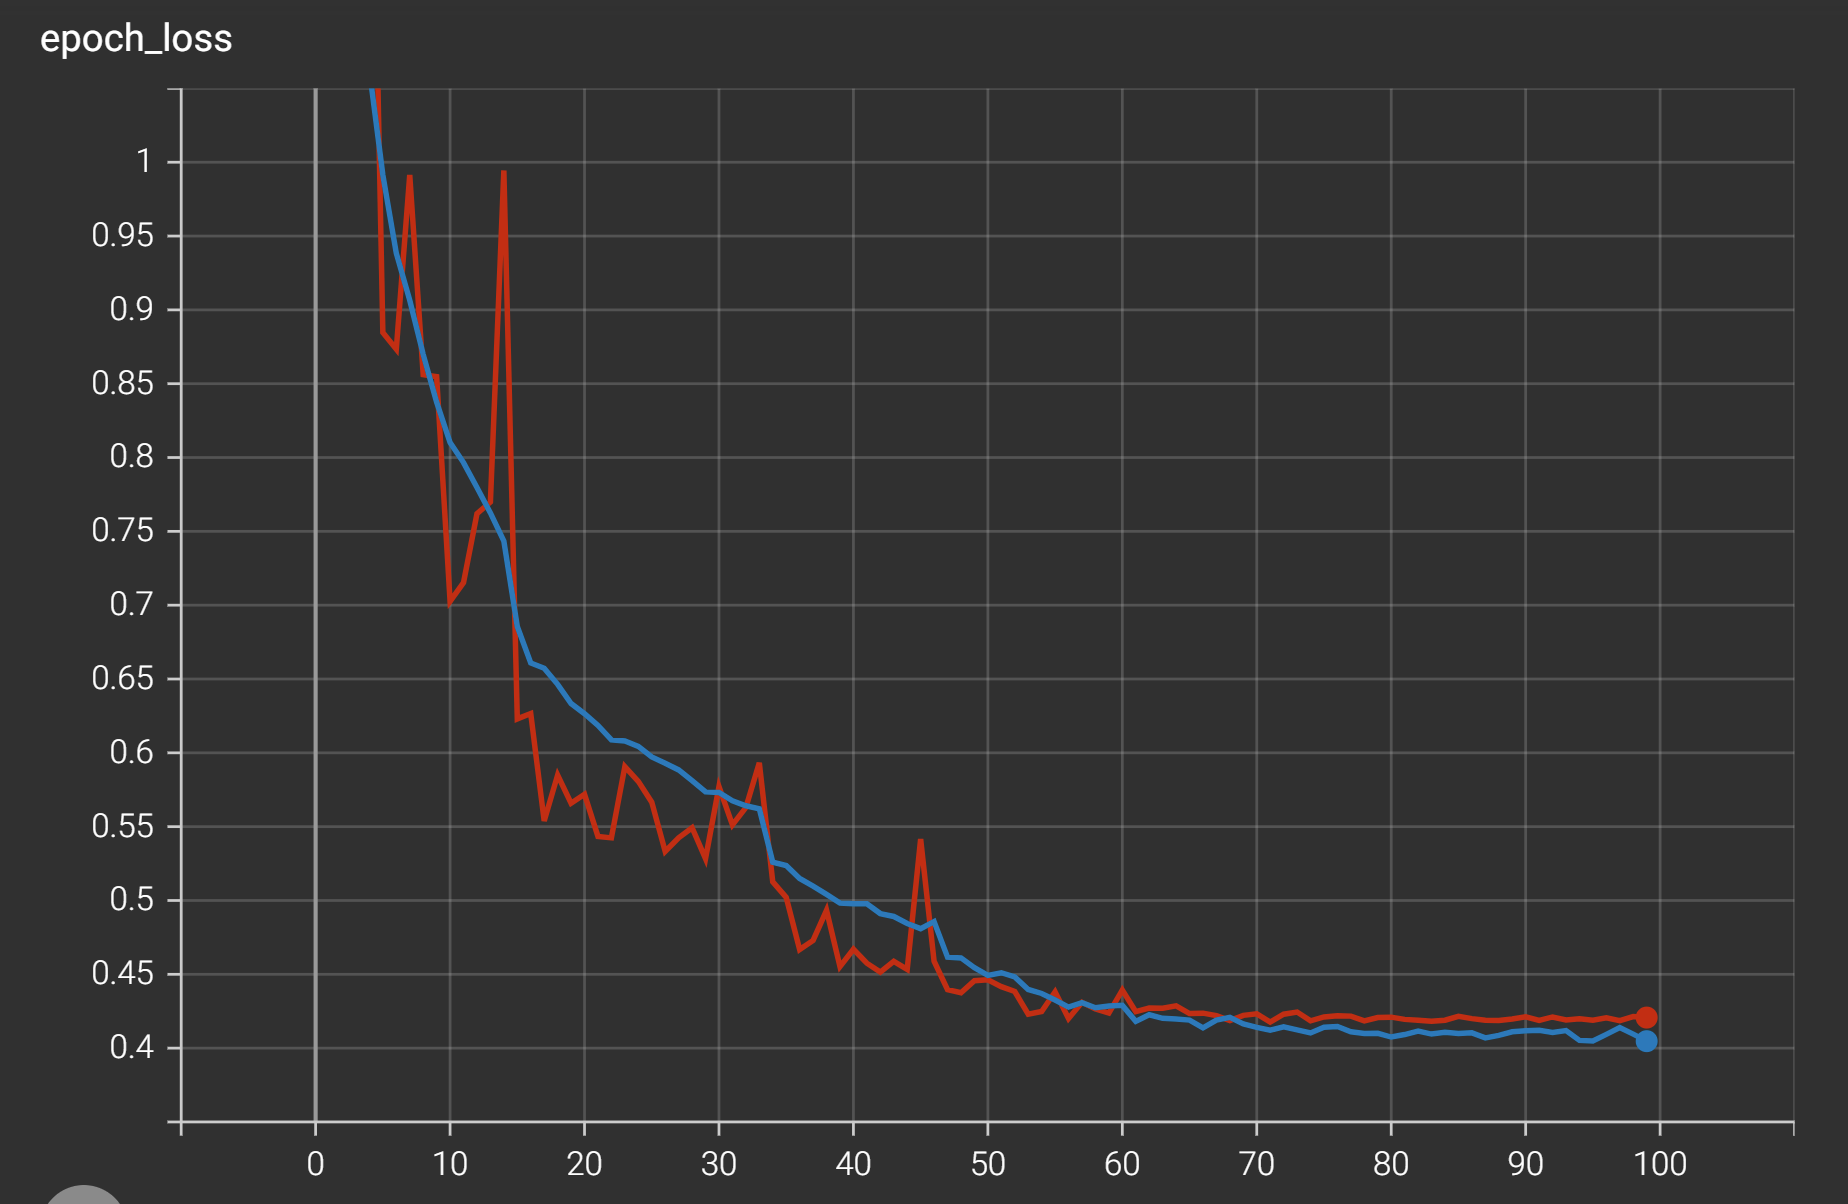